# ResNet
- Won 1st place in the ILSVRC 2015 classification competition with top-5 error rate of 3.57% (An ensemble model)
- Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.
- Replacing VGG-16 layers in Faster R-CNN with ResNet-101. They observed a relative improvements of 28%
- Efficiently trained networks with 100 layers and 1000 layers also.

In [128]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [129]:
import numpy as np
from PIL import Image
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Input
from keras.layers.core import Dense, Flatten 
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import * 
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from keras.preprocessing import image


#TRAIN = 'sample-dog-cat/train'
#VALID = 'sample-dog-cat/valid'
#TEST  = 'sample-dog-cat/test'

TRAIN = 'dogscats/train'
VALID = 'dogscats/valid'
TEST  = 'dogscats/test'

In [130]:
train_batch = ImageDataGenerator().flow_from_directory(TRAIN, target_size=(224,224), batch_size=8)
valid_batch = ImageDataGenerator().flow_from_directory(VALID, target_size=(224,224), batch_size=4)
test_batch = ImageDataGenerator().flow_from_directory(TEST, target_size=(224,224), batch_size=4)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [131]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [132]:
imgs, labels = next(train_batch)

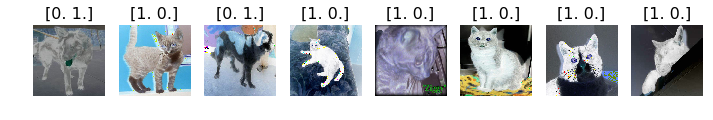

In [133]:
plots(imgs, titles=labels)

### NOTE: Downloading model from official release page may take time, hence run following command before your first run!

In [134]:
r50_model = keras.applications.resnet50.ResNet50(weights='imagenet')

In [135]:
r50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [136]:
r50_model.layers.pop()

In [137]:
for layer in r50_model.layers:
    layer.trainable = False
    
r50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [138]:
new_layer = Dense(2, activation='softmax', name='my_dense')

inp = r50_model.input
out = new_layer(r50_model.layers[-1].output)

new_r50_model = Model(inp, out)
new_r50_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [139]:
new_r50_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=(['accuracy']))
#model.compile(SGD(lr=0.001), loss='categorical_crossentropy', metrics=(['accuracy']))

In [140]:
#model.fit_generator(train_batch, steps_per_epoch=154, validation_data=valid_batch, validation_steps=27, epochs=5, verbose=2)
new_r50_model.fit_generator(train_batch, steps_per_epoch=4, validation_data=valid_batch, validation_steps=4, epochs=3, verbose=2)



Epoch 1/3
 - 25s - loss: 0.8331 - acc: 0.4688 - val_loss: 1.0296 - val_acc: 0.6250
Epoch 2/3
 - 17s - loss: 0.9781 - acc: 0.4375 - val_loss: 0.4991 - val_acc: 0.6875
Epoch 3/3
 - 17s - loss: 0.6512 - acc: 0.6562 - val_loss: 0.5367 - val_acc: 0.8125


In [141]:
tst_imgs, tst_labels = next(test_batch)

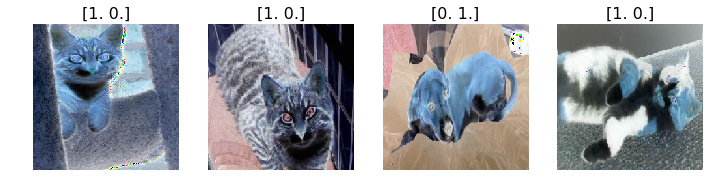

In [142]:
plots(tst_imgs, titles=tst_labels)

In [143]:
tst_labels = tst_labels[:,0]
tst_labels

array([1., 1., 0., 1.], dtype=float32)

In [144]:
predictions = new_r50_model.predict_generator(test_batch, steps=1, verbose=0)
#predictions = model.predict_classes(test_batch, steps=1, verbose=1)

In [145]:
print predictions

[[0.83738023 0.16261975]
 [0.9562655  0.04373443]
 [0.75113386 0.24886613]
 [0.85400385 0.1459962 ]]


In [146]:
cm = confusion_matrix(tst_labels, np.round(predictions[:,0]))

In [147]:
cm_plot_labels = ['cat', 'dog']

In [148]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 1]
 [0 3]]


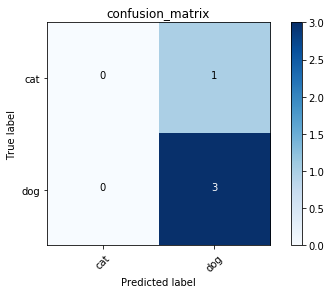

In [149]:
plot_confusion_matrix(cm, cm_plot_labels, title='confusion_matrix')